Actor-Critic = temporal difference learning, represents policy independent of value
<br><br>
Policy = actor, outputs actions given a state
<br>
Value = critic, evaluates

In [2]:
!pip install gym[classic_control]
!pip install pyglet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 20.0 MB/s eta 0:00:00
  Attempting uninstall: pygame
    Found existing installation: pygame 2.6.0
    Uninstalling pygame-2.6.0:
      Successfully uninstalled pygame-2.6.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 929.1/929.1 kB 11.4 MB/s eta 0:00:00


In [4]:
# packages for visualization
!sudo apt-get install -y python-opengl > /dev/null 2>&1
!pip install git+https://github.com/tensorflow/docs > /dev/null 2>&1

In [6]:
import collections
import gym
import numpy as np
import statistics
import tensorflow as tf
import tqdm

import matplotlib.pyplot as plt
from tensorflow.keras import layers

from typing import Any, List, Sequence, Tuple

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
env = gym.make('CartPole-v1')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [10]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

eps = np.finfo(np.float32).eps.item()  # for numerical stability

In [12]:
class ActorCritic(tf.keras.Model):
  def __init__(self, num_actions: int, num_hidden_units: int):
    super().__init__()

    self.common = layers.Dense(num_hidden_units, activation='relu')
    self.actor = layers.Dense(num_actions)  # output n action probabilities
    self.critic = layers.Dense(1)  # output 1 Value

  def call(self, inputs: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
    x = self.common(inputs)
    return self.actor(x), self.critic(x)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
num_actions = env.action_space.n  # move left or move right
num_hidden_units = 128

model = ActorCritic(num_actions, num_hidden_units)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [51]:
# wrap env.step with TF function so it can be included in TF graph
@tf.numpy_function(Tout=[tf.float32, tf.int32, tf.int32])
def env_step(action: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
  state, reward, done, info = env.step(action)
  return (
      state.astype(np.float32),
      np.array(reward, np.int32),
      np.array(done, np.int32)
          )

def run_episode(
    initial_state: tf.Tensor,
    model: tf.keras.Model,
    max_steps: int
) -> Tuple[tf.Tensor, tf.Tensor, tf.Tensor]:
  # use TensorArray for iteration on variable length arrays
  action_probs = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
  values = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
  rewards = tf.TensorArray(dtype=tf.int32, size=0, dynamic_size=True)

  initial_state_shape = initial_state.shape
  state = initial_state

  for t in tf.range(max_steps):
    state = tf.expand_dims(state, 0)  # turn into a batched tensor

    action_logits_t, value = model(state)

    # sample next action from action probability dst
    action = tf.random.categorical(action_logits_t, 1)[0, 0]
    action_probs_t = tf.nn.softmax(action_logits_t)

    # store critic value & log prob of chosen action
    values = values.write(t, tf.squeeze(value))
    action_probs = action_probs.write(t, action_probs_t[0, action])

    state, reward, done = env_step(action)
    state.set_shape(initial_state_shape)

    rewards = rewards.write(t, reward)

    if tf.cast(done, tf.bool): break

  action_probs = action_probs.stack()
  values = values.stack()
  rewards = rewards.stack()

  return action_probs, values, rewards

In [52]:
def get_expected_return(rewards: tf.Tensor, gamma: float, standardize: bool = True) -> tf.Tensor:
  n = tf.shape(rewards)[0]
  returns = tf.TensorArray(dtype=tf.float32, size=n)

  rewards = tf.cast(rewards[::-1], dtype=tf.float32)
  discounted_sum = tf.constant(0.0)
  discounted_sum_shape = discounted_sum.shape

  for i in tf.range(n):  # for each time step
    reward = rewards[i]  # get prev reward (rewards is reversed above)

    discounted_sum = reward + gamma * discounted_sum
    discounted_sum.set_shape(discounted_sum_shape)

    returns = returns.write(i, discounted_sum)

  returns = returns.stack()[::-1]  # reverse it again

  if standardize:  # stabilize training by standardizing returns
    returns = (returns - tf.math.reduce_mean(returns)) / (tf.math.reduce_std(returns) + eps)

  return returns

Actor loss
<br> -ve sum over all time steps (log(policy) * advantage)
<br> advantage = G - V
 - policy = actor
 - V = critic
 - "Advantage"
   - how much better an action is over a random action
   - V is baseline critic, reduces variance in training
   - if 2 actions give same G, V can decide there's no Advantage (G-V = 0) and no benefit in increasing probabilities of the actions
   - V is also our critic, trained to be close to expected return G

<br><br>
Critic loss <br>
want V to be close to G, can use Huber loss like in regression <br>
 - Huber loss is less sensitive to outliers than MSE

In [53]:
huber_loss = tf.keras.losses.Huber(reduction=tf.keras.losses.Reduction.SUM)

def compute_loss(
    action_probs: tf.Tensor,
    values: tf.Tensor,
    returns: tf.Tensor
) -> tf.Tensor:
  advantage = returns - values

  action_log_probs = tf.math.log(action_probs)
  actor_loss = -tf.math.reduce_sum(action_log_probs * advantage)

  critic_loss = huber_loss(values, returns)

  return actor_loss + critic_loss

In [54]:
opt = tf.keras.optimizers.Adam(learning_rate=0.01)

@tf.function  # for speedup
def train_step(
    initial_state: tf.Tensor,
    model: tf.keras.Model,
    opt: tf.keras.optimizers.Optimizer,
    gamma: float,
    max_steps_per_ep: int
) -> tf.Tensor:
  with tf.GradientTape() as tape:
    # gives our training data
    action_probs, values, rewards = run_episode(initial_state, model, max_steps_per_ep)
    returns = get_expected_return(rewards, gamma)

    # reshape
    action_probs, values, returns = [
        tf.expand_dims(x, 1) for x in [action_probs, values, returns]
    ]

    loss = compute_loss(action_probs, values, returns)

  grads = tape.gradient(loss, model.trainable_variables)
  opt.apply_gradients(zip(grads, model.trainable_variables))

  ep_reward = tf.math.reduce_sum(rewards)

  return ep_reward

In [55]:
# %%time

min_eps_criterion = 100
max_eps = 10_000
max_steps_per_ep = 500

reward_thresh = 475  # when do we consider CartPole as solved (reward >= thresh)
running_reward = 0  # for efficiency

gamma = 0.99

eps_reward: collections.deque = collections.deque(maxlen=min_eps_criterion)

t = tqdm.trange(max_eps)
for i in t:
  initial_state = env.reset()

  initial_state = tf.constant(initial_state, dtype=tf.float32)

  ep_reward = int(train_step(
      initial_state, model, opt, gamma, max_steps_per_ep
  ))

  eps_reward.append(ep_reward)
  running_reward = statistics.mean(eps_reward)

  t.set_postfix(ep_reward=ep_reward, running_reward=running_reward)

  if i % 10 == 0: print(f"\nEp {i}, avg reward: {running_reward:.2f}")

  if running_reward > reward_thresh and i >= min_eps_criterion: break

print(f"\nSolved at ep {i}, avg reward: {running_reward:.2f}")

  0%|          | 8/10000 [00:02<34:43,  4.80it/s, ep_reward=10, running_reward=21.4]

Ep 0, avg reward: 33.00
Ep 10, avg reward: 22.45


  0%|          | 29/10000 [00:02<07:20, 22.64it/s, ep_reward=26, running_reward=23.1]

Ep 20, avg reward: 26.05
Ep 30, avg reward: 23.06


  0%|          | 46/10000 [00:03<04:35, 36.11it/s, ep_reward=26, running_reward=22.9]

Ep 40, avg reward: 22.49


  1%|          | 55/10000 [00:03<05:31, 29.95it/s, ep_reward=25, running_reward=25.7]

Ep 50, avg reward: 25.04


  1%|          | 69/10000 [00:03<04:16, 38.74it/s, ep_reward=19, running_reward=25.9]

Ep 60, avg reward: 26.33
Ep 70, avg reward: 25.89


  1%|          | 85/10000 [00:04<03:42, 44.63it/s, ep_reward=49, running_reward=26.4]

Ep 80, avg reward: 26.15


  1%|          | 95/10000 [00:04<03:59, 41.44it/s, ep_reward=30, running_reward=26.3]

Ep 90, avg reward: 26.29


  1%|          | 105/10000 [00:04<04:18, 38.33it/s, ep_reward=35, running_reward=28.2]

Ep 100, avg reward: 26.91


  1%|          | 114/10000 [00:04<04:42, 34.99it/s, ep_reward=50, running_reward=29.6]

Ep 110, avg reward: 28.79


  1%|▏         | 126/10000 [00:05<05:31, 29.79it/s, ep_reward=25, running_reward=32.3]

Ep 120, avg reward: 30.90


  1%|▏         | 134/10000 [00:05<05:43, 28.72it/s, ep_reward=79, running_reward=35.4]

Ep 130, avg reward: 33.90


  1%|▏         | 145/10000 [00:06<05:35, 29.37it/s, ep_reward=33, running_reward=37]  

Ep 140, avg reward: 36.38


  2%|▏         | 157/10000 [00:06<04:59, 32.92it/s, ep_reward=36, running_reward=36.3]

Ep 150, avg reward: 36.26


  2%|▏         | 165/10000 [00:06<04:57, 33.09it/s, ep_reward=45, running_reward=37.9]

Ep 160, avg reward: 36.53


  2%|▏         | 174/10000 [00:06<04:34, 35.78it/s, ep_reward=64, running_reward=40.1]

Ep 170, avg reward: 38.45


  2%|▏         | 182/10000 [00:07<05:40, 28.84it/s, ep_reward=47, running_reward=44.4] 

Ep 180, avg reward: 42.62


  2%|▏         | 195/10000 [00:07<06:44, 24.25it/s, ep_reward=60, running_reward=50.2]

Ep 190, avg reward: 47.30


  2%|▏         | 205/10000 [00:08<06:44, 24.22it/s, ep_reward=77, running_reward=53.9]

Ep 200, avg reward: 52.13


  2%|▏         | 214/10000 [00:08<07:43, 21.13it/s, ep_reward=161, running_reward=59.9]

Ep 210, avg reward: 56.67


  2%|▏         | 224/10000 [00:09<09:17, 17.54it/s, ep_reward=84, running_reward=69.5]

Ep 220, avg reward: 66.96


  2%|▏         | 235/10000 [00:09<07:56, 20.50it/s, ep_reward=91, running_reward=75.1]

Ep 230, avg reward: 72.53


  2%|▏         | 244/10000 [00:10<07:42, 21.09it/s, ep_reward=78, running_reward=78.5]

Ep 240, avg reward: 76.85


  3%|▎         | 253/10000 [00:10<07:56, 20.47it/s, ep_reward=89, running_reward=86.6]

Ep 250, avg reward: 83.91


  3%|▎         | 263/10000 [00:11<09:49, 16.51it/s, ep_reward=17, running_reward=95.2] 

Ep 260, avg reward: 93.10


  3%|▎         | 272/10000 [00:11<08:01, 20.21it/s, ep_reward=79, running_reward=98.4]

Ep 270, avg reward: 97.08


  3%|▎         | 285/10000 [00:12<07:11, 22.52it/s, ep_reward=103, running_reward=100]

Ep 280, avg reward: 101.27


  3%|▎         | 291/10000 [00:12<08:21, 19.35it/s, ep_reward=131, running_reward=104]

Ep 290, avg reward: 103.15


  3%|▎         | 302/10000 [00:13<14:47, 10.93it/s, ep_reward=350, running_reward=115]

Ep 300, avg reward: 112.32


  3%|▎         | 312/10000 [00:15<25:05,  6.44it/s, ep_reward=219, running_reward=148]

Ep 310, avg reward: 147.24


  3%|▎         | 323/10000 [00:16<09:46, 16.49it/s, ep_reward=114, running_reward=147]

Ep 320, avg reward: 147.20


  3%|▎         | 333/10000 [00:16<09:37, 16.74it/s, ep_reward=143, running_reward=148]

Ep 330, avg reward: 147.38


  3%|▎         | 341/10000 [00:17<15:11, 10.60it/s, ep_reward=189, running_reward=156]

Ep 340, avg reward: 155.35


  4%|▎         | 352/10000 [00:19<29:48,  5.40it/s, ep_reward=299, running_reward=181]

Ep 350, avg reward: 179.37


  4%|▎         | 361/10000 [00:21<34:01,  4.72it/s, ep_reward=500, running_reward=212]

Ep 360, avg reward: 211.74


  4%|▎         | 373/10000 [00:23<16:50,  9.53it/s, ep_reward=192, running_reward=241]

Ep 370, avg reward: 240.04


  4%|▍         | 381/10000 [00:24<13:00, 12.32it/s, ep_reward=300, running_reward=248]

Ep 380, avg reward: 244.74


  4%|▍         | 393/10000 [00:25<14:09, 11.31it/s, ep_reward=236, running_reward=256]

Ep 390, avg reward: 255.12


  4%|▍         | 401/10000 [00:26<14:14, 11.23it/s, ep_reward=246, running_reward=258]

Ep 400, avg reward: 259.21


  4%|▍         | 411/10000 [00:27<25:38,  6.23it/s, ep_reward=500, running_reward=252]

Ep 410, avg reward: 251.74


  4%|▍         | 422/10000 [00:29<31:04,  5.14it/s, ep_reward=104, running_reward=280]

Ep 420, avg reward: 278.82


  4%|▍         | 431/10000 [00:33<1:33:23,  1.71it/s, ep_reward=500, running_reward=304]

Ep 430, avg reward: 304.06


  4%|▍         | 442/10000 [00:37<39:10,  4.07it/s, ep_reward=420, running_reward=336]

Ep 440, avg reward: 333.89


  5%|▍         | 451/10000 [00:39<33:04,  4.81it/s, ep_reward=500, running_reward=344]

Ep 450, avg reward: 343.75


  5%|▍         | 461/10000 [00:41<34:09,  4.66it/s, ep_reward=500, running_reward=349]

Ep 460, avg reward: 348.63


  5%|▍         | 473/10000 [00:42<16:18,  9.74it/s, ep_reward=122, running_reward=336]

Ep 470, avg reward: 337.60


  5%|▍         | 483/10000 [00:43<09:16, 17.11it/s, ep_reward=38, running_reward=328]

Ep 480, avg reward: 333.26


  5%|▍         | 496/10000 [00:43<06:30, 24.35it/s, ep_reward=104, running_reward=315]

Ep 490, avg reward: 321.46


  5%|▌         | 505/10000 [00:44<07:13, 21.88it/s, ep_reward=106, running_reward=299]

Ep 500, avg reward: 308.17


  5%|▌         | 514/10000 [00:44<08:04, 19.59it/s, ep_reward=117, running_reward=273]

Ep 510, avg reward: 281.97


  5%|▌         | 522/10000 [00:45<10:02, 15.73it/s, ep_reward=109, running_reward=249]

Ep 520, avg reward: 250.68


  5%|▌         | 534/10000 [00:45<10:54, 14.46it/s, ep_reward=119, running_reward=215]

Ep 530, avg reward: 226.43


  5%|▌         | 542/10000 [00:46<12:29, 12.61it/s, ep_reward=119, running_reward=187]

Ep 540, avg reward: 191.93


  6%|▌         | 554/10000 [00:47<11:39, 13.50it/s, ep_reward=112, running_reward=148]

Ep 550, avg reward: 159.41


  6%|▌         | 562/10000 [00:48<10:49, 14.52it/s, ep_reward=115, running_reward=116]

Ep 560, avg reward: 120.75


  6%|▌         | 574/10000 [00:48<09:29, 16.56it/s, ep_reward=106, running_reward=106]

Ep 570, avg reward: 106.85


  6%|▌         | 584/10000 [00:49<08:49, 17.78it/s, ep_reward=120, running_reward=108]

Ep 580, avg reward: 107.06


  6%|▌         | 595/10000 [00:49<08:16, 18.93it/s, ep_reward=121, running_reward=113]

Ep 590, avg reward: 111.28


  6%|▌         | 603/10000 [00:50<09:07, 17.16it/s, ep_reward=128, running_reward=116]

Ep 600, avg reward: 115.13


  6%|▌         | 613/10000 [00:51<10:40, 14.65it/s, ep_reward=140, running_reward=120]

Ep 610, avg reward: 119.51


  6%|▌         | 623/10000 [00:52<13:36, 11.49it/s, ep_reward=186, running_reward=131]

Ep 620, avg reward: 129.36


  6%|▋         | 631/10000 [00:53<27:45,  5.62it/s, ep_reward=500, running_reward=156]

Ep 630, avg reward: 156.40


  6%|▋         | 641/10000 [00:55<32:51,  4.75it/s, ep_reward=500, running_reward=194]

Ep 640, avg reward: 194.23


  7%|▋         | 651/10000 [00:57<32:48,  4.75it/s, ep_reward=500, running_reward=232]

Ep 650, avg reward: 232.38


  7%|▋         | 661/10000 [01:00<44:33,  3.49it/s, ep_reward=500, running_reward=271]

Ep 660, avg reward: 271.04


  7%|▋         | 671/10000 [01:03<35:28,  4.38it/s, ep_reward=500, running_reward=309]

Ep 670, avg reward: 309.45


  7%|▋         | 681/10000 [01:05<30:35,  5.08it/s, ep_reward=500, running_reward=341]

Ep 680, avg reward: 341.14


  7%|▋         | 691/10000 [01:07<32:49,  4.73it/s, ep_reward=500, running_reward=379]

Ep 690, avg reward: 378.69


  7%|▋         | 701/10000 [01:09<33:22,  4.64it/s, ep_reward=500, running_reward=417]

Ep 700, avg reward: 416.72


  7%|▋         | 711/10000 [01:11<33:27,  4.63it/s, ep_reward=500, running_reward=453]

Ep 710, avg reward: 452.53


  7%|▋         | 719/10000 [01:14<15:56,  9.71it/s, ep_reward=500, running_reward=478]

Solved at ep 719, avg reward: 478.01


In [67]:
# visualize an episode

from IPython import display as ipythondisplay
from PIL import Image

render_env = gym.make('CartPole-v1', render_mode='rgb_array')

def render_ep(env: gym.Env, model: tf.keras.Model, max_steps: int):
  state = env.reset()
  state = tf.constant(state, dtype=tf.float32)

  screen = env.render()
  screen = np.asarray(screen)[0]
  imgs = [Image.fromarray(screen)]

  for i in range(1, max_steps+1):
    state = tf.expand_dims(state, 0)

    action_probs, _ = model(state)
    action = np.argmax(np.squeeze(action_probs))

    state, reward, done, info = env.step(action)
    state = tf.constant(state, dtype=tf.float32)

    if i % 10 == 0:
      screen = env.render()
      screen = np.asarray(screen)[0]
      imgs.append(Image.fromarray(screen))

    if done: break

  return imgs

imgs = render_ep(render_env, model, max_steps_per_ep)
img_file = 'cartpole-v1.gif'
# loop forever, play each frame for 1ms duration
imgs[0].save(img_file, save_all=True, append_images=imgs[1:], loop=0, duration=1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym


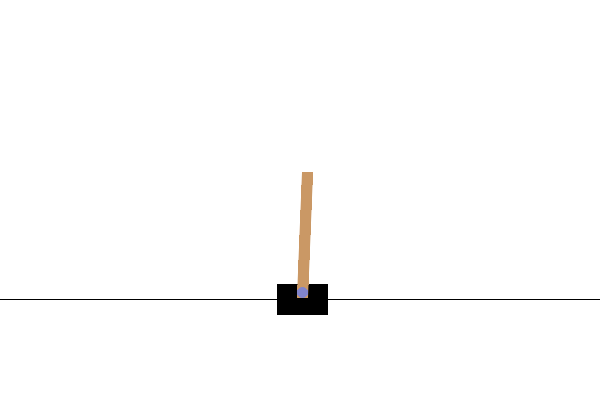

In [68]:
import tensorflow_docs.vis.embed as embed

embed.embed_file(img_file)